# On Periodic Spike Trains

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
%matplotlib inline

## Number of Firings

In [10]:
from rsnn.spike_train.utils import pmf_num_spikes

In [11]:
period, firing_rate = 100000, 0.2

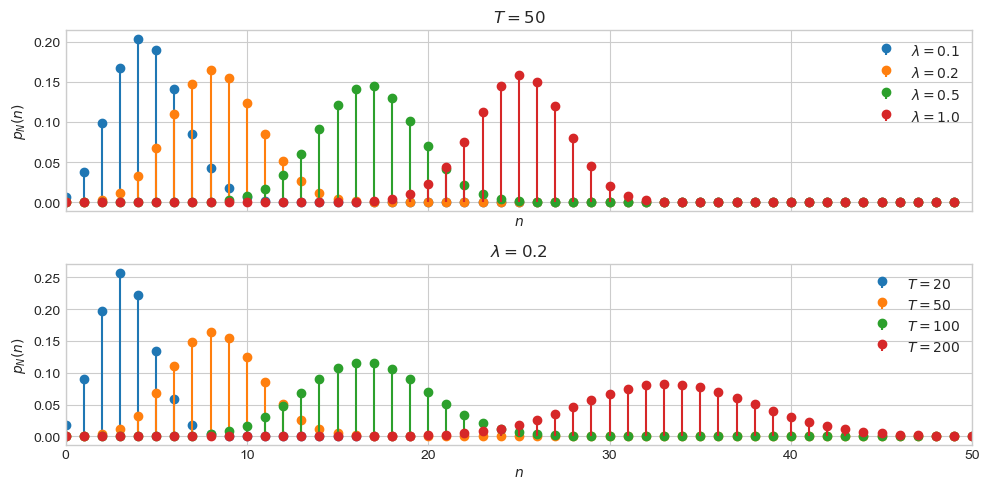

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True)

for i, firing_rate in enumerate([0.1, 0.2, 0.5, 1.0]):
    ns, pns = pmf_num_spikes(50, firing_rate)
    axes[0].stem(ns, pns, basefmt=" ", markerfmt=f"C{i}o", linefmt=f"C{i}", label=f"$\lambda = {firing_rate:.1f}$")
    
axes[0].set_xlabel("$n$")
axes[0].set_ylabel("$p_N(n)$")
axes[0].set_title("$T = 50$")
axes[0].legend()

for i, period in enumerate([20, 50, 100, 200]):
    ns, pns = pmf_num_spikes(period, 0.2)
    axes[1].stem(ns, pns, basefmt=" ", markerfmt=f"C{i}o", linefmt=f"C{i}", label=f"$T = {period}$")
    
axes[1].set_xlim(0, 50)
axes[1].set_xlabel("$n$")
axes[1].set_ylabel("$p_N(n)$")
axes[1].set_title("$\lambda = 0.2$")
axes[1].legend()

fig.tight_layout()

plt.show()

## Empty Spike Trains

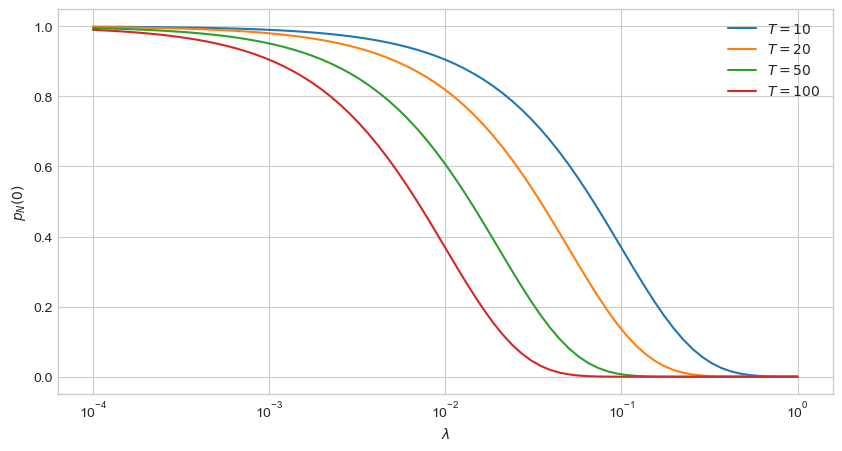

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

periods = [10, 20, 50, 100]
firing_rates = np.logspace(-4, 0, 75)

for i, period in enumerate(periods):
    p0 = [pmf_num_spikes(period, firing_rate)[1][0] for firing_rate in firing_rates]
    ax.semilogx(firing_rates, p0, color=f"C{i}")

ax.set_xlabel("$\lambda$")
ax.set_ylabel("$p_N(0)$")
ax.legend([f"$T = {period}$" for period in periods])

plt.show()

## Sampling

In [28]:
from rsnn.spike_train.sampler import sample_spike_trains

In [58]:
def check_refractoriness(spike_trains, period):
    for fts in spike_trains:
        if len(fts) > 1 and np.any((fts - np.roll(fts, 1)) % period <= 1):
            return False
    return True

def check_period(spike_trains, period):
    for fts in spike_trains:
        if len(fts) > 1 and np.max(fts) >= period:
            return False
    return True

In [87]:
period, firing_rate = 100, 0.2

In [88]:
spike_trains = sample_spike_trains(period, firing_rate, 10000)
print("refractoriness:", "ok" if check_refractoriness(spike_trains, period) else "not ok")
print("period:", "ok" if check_period(spike_trains, period) else "not ok")

refractoriness: ok
period: ok


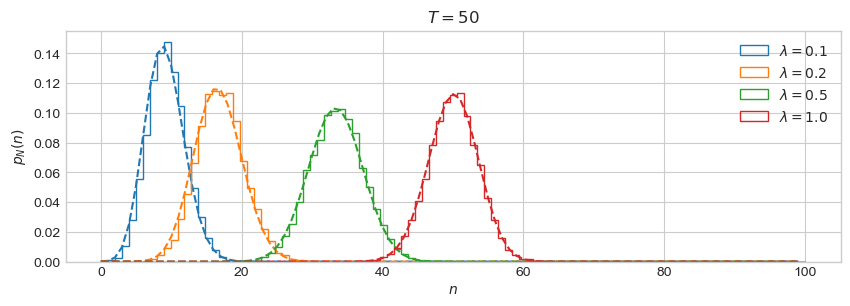

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))

for i, firing_rate in enumerate([0.1, 0.2, 0.5, 1.0]):
    spike_trains = sample_spike_trains(period, firing_rate, 10000)
    num_spikes = [len(fts) for fts in spike_trains]
    ax.hist(num_spikes, bins=period//1 + 1, range=(0,period), color=f"C{i}", histtype="step", label=f"$\lambda = {firing_rate:.1f}$", density=True)
    ns, pns = pmf_num_spikes(period, firing_rate)
    ax.plot(ns, pns, linestyle="dashed", color=f"C{i}")

    
ax.set_xlabel("$n$")
ax.set_ylabel("$p_N(n)$")
ax.set_title("$T = 50$")
ax.legend()

plt.show()

## Expected Number of Firings

In [92]:
from rsnn.spike_train.utils import expected_num_spikes

In [93]:
period, firing_rate = 100, 0.2

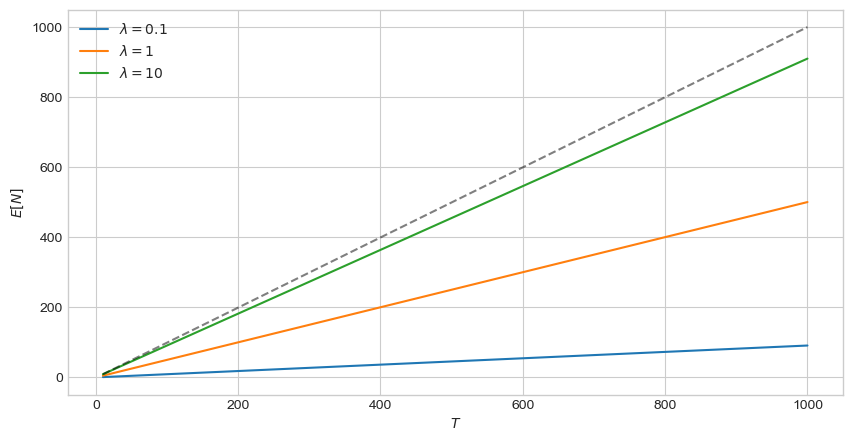

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i, firing_rate in enumerate([1e-1, 1, 10]):
    exp_n = [expected_num_spikes(period, firing_rate) for period in np.logspace(1, 3, 100)]
    ax.plot(np.logspace(1, 3, 100), exp_n, color=f"C{i}", label=f"$\lambda = {firing_rate}$")

ax.plot(np.logspace(1, 3, 100), np.logspace(1, 3, 100)-1, color="black", linestyle="dashed", alpha=0.5)

ax.set_xlabel("$T$")
ax.set_ylabel("$E[N]$")
ax.legend()

plt.show()

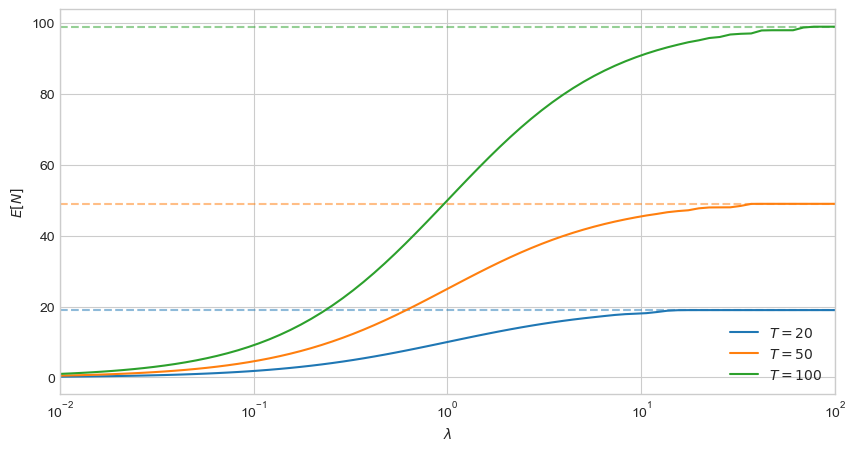

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

for i, period in enumerate([20, 50, 100]):
    exp_n = [expected_num_spikes(period, firing_rate) for firing_rate in np.logspace(-2, 2, 75)]
    ax.semilogx(np.logspace(-2, 2, 75), exp_n, color=f"C{i}", label=f"$T = {period}$")
    ax.axhline(period-1, color=f"C{i}", linestyle="dashed", alpha=0.5)

ax.set_xlim(1e-2, 1e2)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$E[N]$")
ax.legend()

plt.show()

In [96]:
period, firing_rate = 50, 0.2
print("empirical expected number of spikes:", np.mean([len(fts) for fts in sample_spike_trains(period, firing_rate, 10000)]))
print("theoretical expected number of spikes:", expected_num_spikes(period, firing_rate))

empirical expected number of spikes: 8.3418
theoretical expected number of spikes: 8.333333333333332


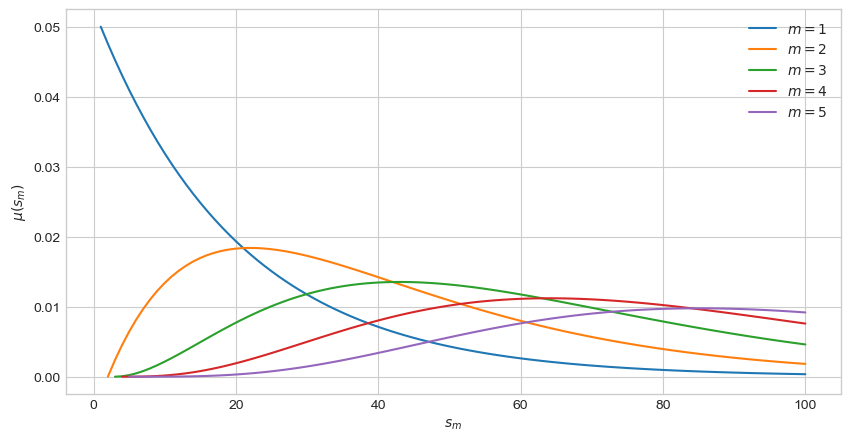

In [97]:
def forward_msg(firing_rate, m, tms, t0=0.0):
    lnmfms = (m-1)*np.log(tms - t0 - m) - firing_rate*(tms - t0 - m) + m * np.log(firing_rate) - np.sum(np.log(np.arange(1, m)))
    mfms = np.exp(lnmfms)
    return mfms

fig, ax = plt.subplots(1, 1, figsize=(10,5))

period, firing_rate = 100, 0.05
n = 6

for m in range(1, n):
    tms = np.linspace(m + 1e-6, period, 100)
    ax.plot(tms, forward_msg(firing_rate, m, tms), color=f"C{m-1}", label=f"$m = {m}$")

ax.set_xlabel("$s_m$")
ax.set_ylabel("$\mu(s_m)$")
ax.legend()

plt.show()

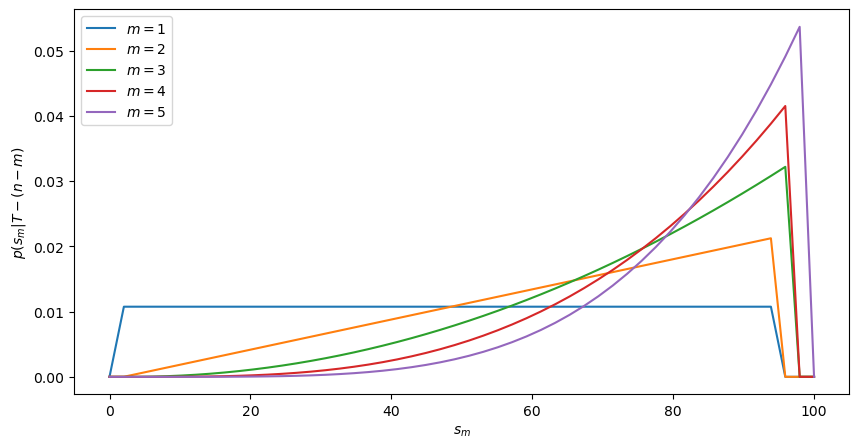

In [23]:
def cond_prob(m, ft, next_ft):
    return (ft > m) * (ft < next_ft - 1) * m * np.power((ft - m)/(next_ft - (m+1)), m-1) / (next_ft - (m+1))
    
    #pfs = np.nan_to_num(m*np.power((t - m)/(period - (n - m + 1)), m-1)/(period - (n - m + 1)))
    ##ptms = ptms / ptms.sum() * (period - (m+1))
    #return ptms
    
fig, ax = plt.subplots(1, 1, figsize=(10,5))

period, firing_rate = 100, 0.2
n = 6
res = 0.1

for m in range(1, n):
    ft = np.linspace(0, period)
    ax.plot(ft, cond_prob(m, ft, period - (n - m)), color=f"C{m-1}", label=f"$m = {m}$")

ax.set_xlabel("$s_m$")
ax.set_ylabel("$p(s_m | T - (n - m)$")
ax.legend()

plt.show()